## 1. Installation

First, install the aimclub ECG library and its dependencies.

In [41]:
# Install the aimclub ECG library
!pip install git+https://github.com/aimclub/ECG.git

# Install additional dependencies if needed
# Note: cv2 is installed as opencv-python, grad-cam is installed as grad_cam
!pip install neurokit2 torch scipy matplotlib numpy pandas opencv-python grad-cam pillow

  Cloning https://github.com/aimclub/ECG.git to /private/var/folders/h3/wqx2fl614dqbywwpdbx490qw0000gn/T/pip-req-build-cwvf5h3c
  Running command git clone --filter=blob:none --quiet https://github.com/aimclub/ECG.git /private/var/folders/h3/wqx2fl614dqbywwpdbx490qw0000gn/T/pip-req-build-cwvf5h3c
  Resolved https://github.com/aimclub/ECG.git to commit d474c90a1ccf97074e3833ff40e1cdd0428b05e2
  Installing build dependencies ...   Resolved https://github.com/aimclub/ECG.git to commit d474c90a1ccf97074e3833ff40e1cdd0428b05e2
  Installing build dependencies ... -done
  Getting requirements to build wheel ... one
  Getting requirements to build wheel ... done
done
  Preparing metadata (pyproject.toml) ...   Preparing metadata (pyproject.toml) ... done
done


## 2. Import Libraries

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Import aimclub ECG API
import ECG.api as ecg_api
from ECG.data_classes import ElevatedST, Diagnosis, RiskMarkers, Failed
from ECG.ecghealthcheck.enums import ECGClass

print("Libraries imported successfully!")

Libraries imported successfully!


## 3. Load and Prepare Your ECG Data

Your data is in a tab-delimited format with 8 channels (CH1-CH8). We'll load it and prepare it for the aimclub library.

In [43]:
# Load the ECG data
file_path = 'Device_1_Volts.txt'

# Skip the header rows (first 6 rows contain metadata)
data = pd.read_csv(file_path, sep='\t', skiprows=6, header=0)

# Drop any unnamed/empty columns
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# Display basic info
print(f"Data shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")
print(f"\nFirst few rows:")
print(data.head())

# Display data statistics
print(f"\nData statistics:")
print(data.describe())

Data shape: (10000, 8)
Columns: ['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8']

First few rows:
        CH1       CH2       CH3       CH4  CH5       CH6       CH7  CH8
0  0.084526  0.005295  0.012004 -0.369959 -0.4  0.220247  0.104263 -0.4
1  0.084529  0.005295  0.011996 -0.369946 -0.4  0.220252  0.104269 -0.4
2  0.084531  0.005285  0.011995 -0.369932 -0.4  0.220267  0.104279 -0.4
3  0.084530  0.005280  0.011974 -0.369967 -0.4  0.220233  0.104246 -0.4
4  0.084531  0.005289  0.011974 -0.370012 -0.4  0.220187  0.104201 -0.4

Data statistics:
                CH1           CH2           CH3           CH4           CH5  \
count  10000.000000  10000.000000  10000.000000  10000.000000  1.000000e+04   
mean       0.082124      0.004949      0.011751     -0.335250 -4.000000e-01   
std        0.001591      0.000183      0.000516      0.018003  5.551393e-17   
min        0.079297      0.004336      0.010288     -0.370371 -4.000000e-01   
25%        0.080641      0.004816      0.011408  

In [44]:
# Convert to numpy array and transpose to get channels as rows
# Original shape: (samples, 8 channels) -> Need: (8 channels, samples)
ecg_data_8ch = data.values.T

print(f"ECG data shape (8 channels): {ecg_data_8ch.shape}")
print(f"Number of channels: {ecg_data_8ch.shape[0]}")
print(f"Number of samples: {ecg_data_8ch.shape[1]}")

# Calculate duration (assuming 500 Hz sampling rate required by library)
sampling_rate = 500  # Hz (required by aimclub library)
duration = ecg_data_8ch.shape[1] / sampling_rate
print(f"\nDuration: {duration:.2f} seconds")
print(f"Meets minimum 5s requirement: {duration >= 5}")

ECG data shape (8 channels): (8, 10000)
Number of channels: 8
Number of samples: 10000

Duration: 20.00 seconds
Meets minimum 5s requirement: True


## 4. Prepare 12-Lead Format

The aimclub library expects 12-lead ECG format. Since we only have 8 channels, we'll:
1. Use the 8 available channels
2. Pad with zeros or duplicate channels to create 12 leads

In [45]:
# Create 12-lead format by duplicating channels
# Standard 12-lead: I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5, V6
num_samples = ecg_data_8ch.shape[1]

# Create 12-lead array
ecg_12_lead = np.zeros((12, num_samples))

# Copy available 8 channels
ecg_12_lead[:8, :] = ecg_data_8ch

# Duplicate some channels to fill the remaining 4 leads
# This is better than zeros as it provides realistic signal data
# Duplicate channels 4-7 to fill positions 8-11
ecg_12_lead[8:12, :] = ecg_data_8ch[4:8, :]

print(f"12-lead ECG shape: {ecg_12_lead.shape}")
print(f"Ready for aimclub library: {ecg_12_lead.shape[0] == 12}")
print(f"\nChannel mapping:")
print(f"  Leads 0-7: Original CH1-CH8")
print(f"  Leads 8-11: Duplicated from CH5-CH8")

12-lead ECG shape: (12, 10000)
Ready for aimclub library: True

Channel mapping:
  Leads 0-7: Original CH1-CH8
  Leads 8-11: Duplicated from CH5-CH8


## 5. Visualize the ECG Signal

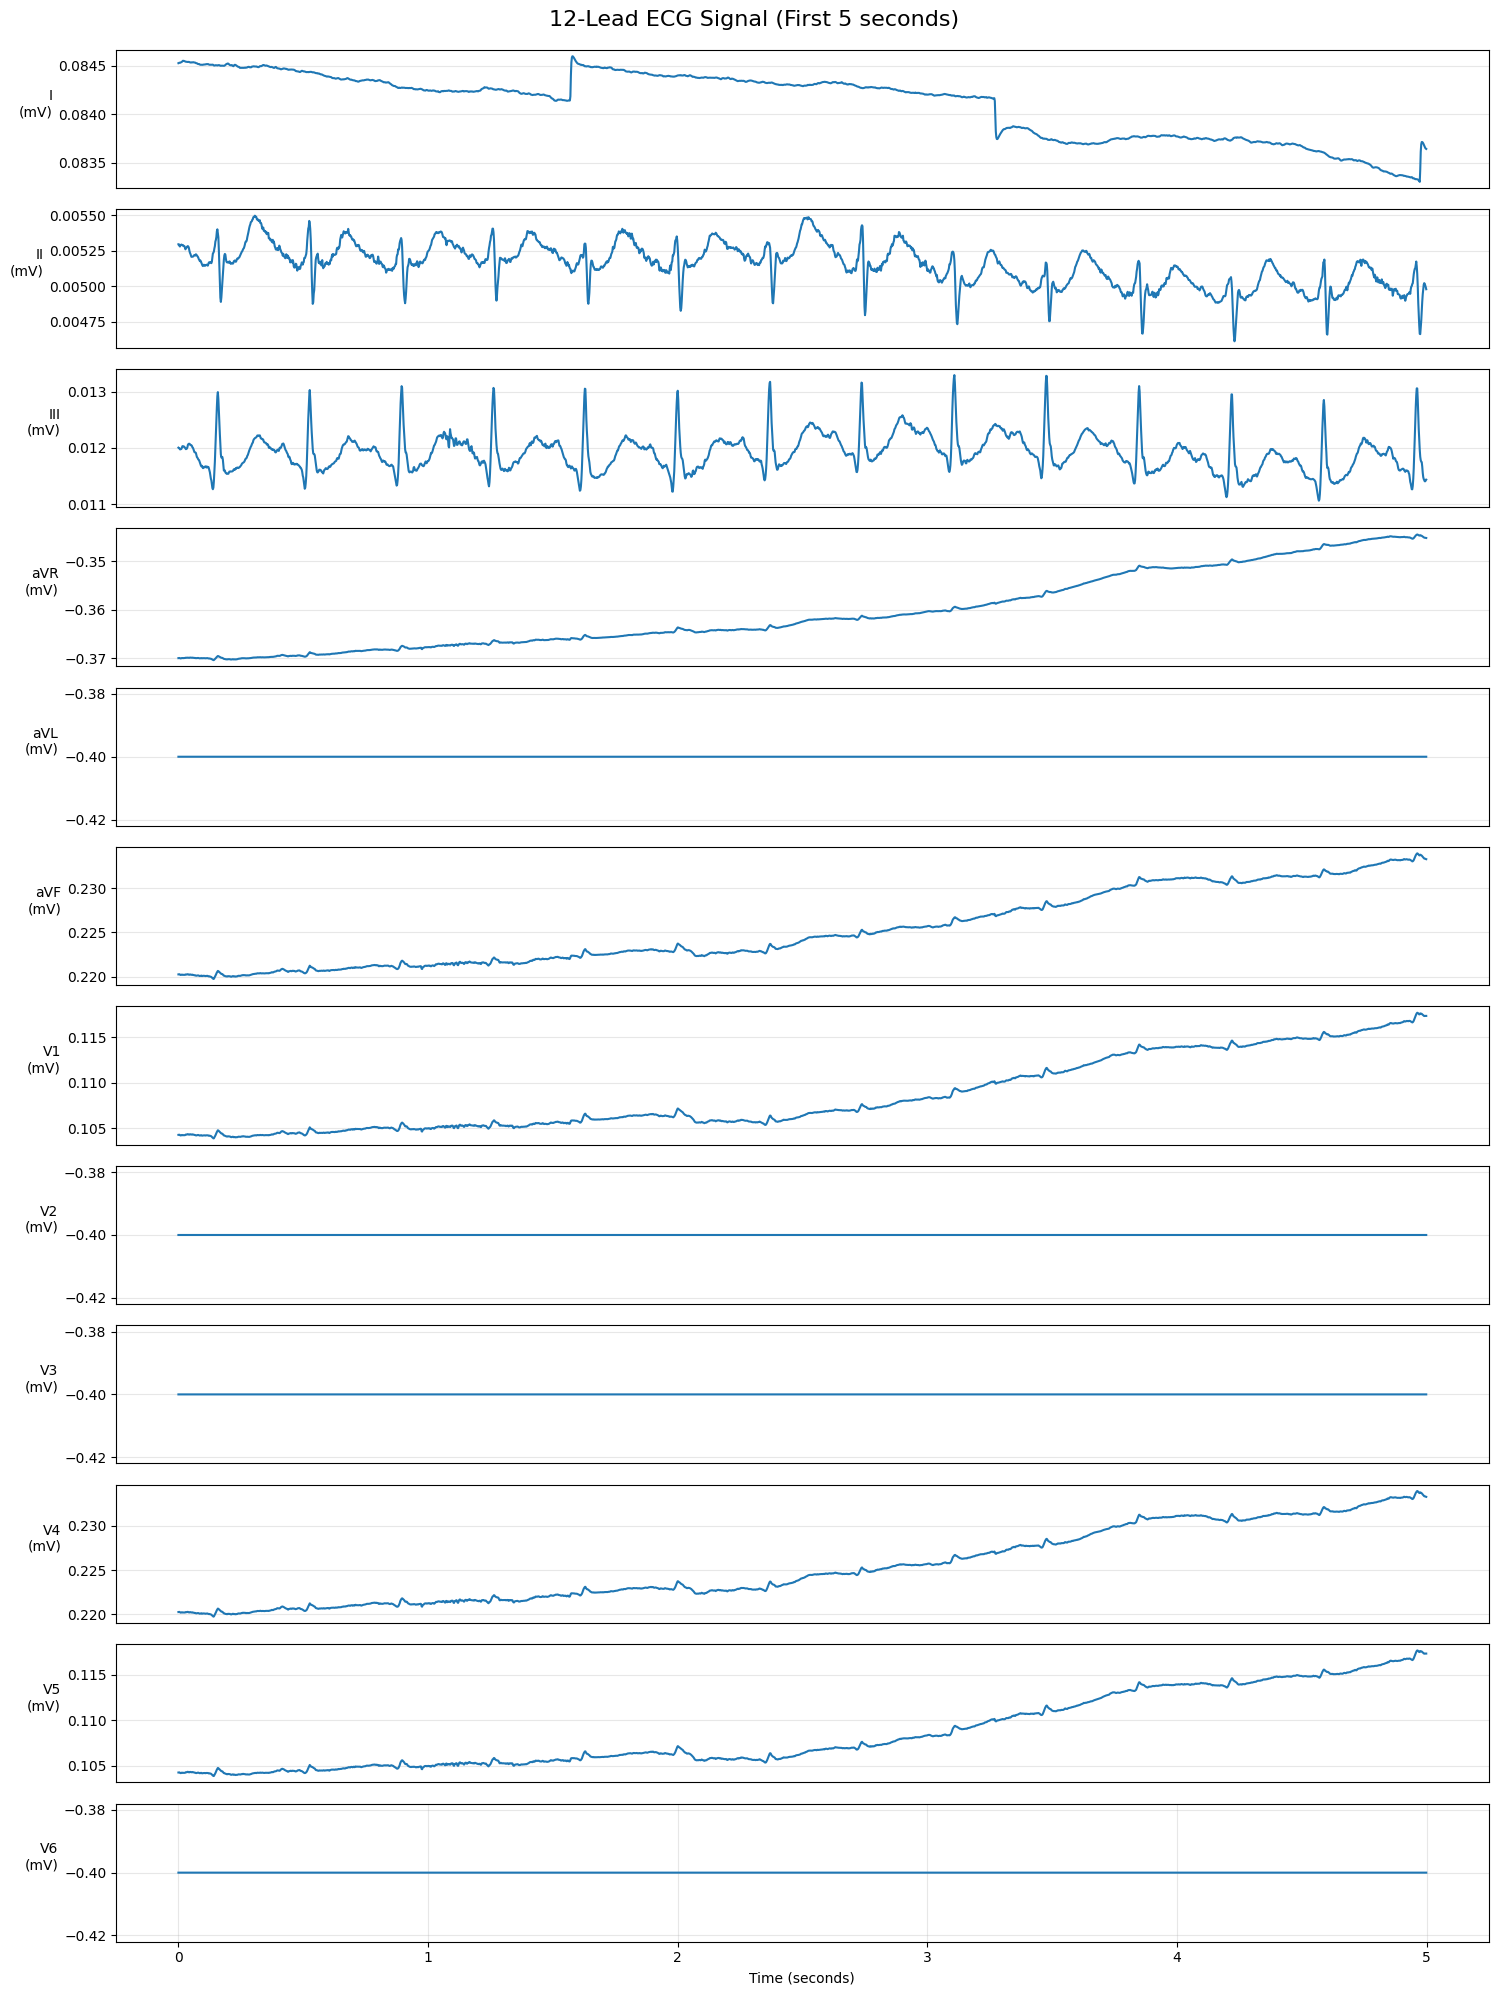

In [46]:
# Plot first few seconds of all 12 leads
fig, axes = plt.subplots(12, 1, figsize=(15, 20))
lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

time_window = 5  # seconds to display
samples_to_plot = int(time_window * sampling_rate)
time_axis = np.arange(samples_to_plot) / sampling_rate

for i in range(12):
    axes[i].plot(time_axis, ecg_12_lead[i, :samples_to_plot])
    axes[i].set_ylabel(f'{lead_names[i]}\n(mV)', rotation=0, ha='right')
    axes[i].grid(True, alpha=0.3)
    if i < 11:
        axes[i].set_xticks([])

axes[-1].set_xlabel('Time (seconds)')
fig.suptitle('12-Lead ECG Signal (First 5 seconds)', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

## 6. Test ST-Elevation Detection (Classic Method)

In [47]:
# Check for ST elevation using classic CV methods
try:
    st_result = ecg_api.check_ST_elevation(ecg_12_lead, sampling_rate=sampling_rate)
    
    if isinstance(st_result, Failed):
        print(f"ST-Elevation Detection Failed: {st_result.reason}")
        if st_result.exception:
            print(f"Exception: {st_result.exception}")
    else:
        st_status, st_explanation = st_result
        print("=== ST-Elevation Detection (Classic Method) ===")
        print(f"Status: {st_status.value}")
        print(f"Explanation: {st_explanation.content}")
except Exception as e:
    print(f"Error during ST-elevation detection: {e}")

ST-Elevation Detection Failed: Failed to assess ST elevation due to an internal error
Exception: tuple indices must be integers or slices, not numpy.bool


## 7. Test ST-Elevation Detection (Neural Network Method)

In [48]:
# Check for ST elevation using Neural Network
try:
    st_nn_result = ecg_api.check_ST_elevation_with_NN(ecg_12_lead)
    
    if isinstance(st_nn_result, Failed):
        print(f"ST-Elevation Detection (NN) Failed: {st_nn_result.reason}")
    else:
        st_nn_status, st_nn_explanation = st_nn_result
        print("=== ST-Elevation Detection (Neural Network) ===")
        print(f"Status: {st_nn_status.value}")
        print(f"Explanation: {st_nn_explanation.text}")
        
        # Display GradCAM visualization
        if st_nn_explanation.image:
            plt.figure(figsize=(12, 6))
            plt.imshow(st_nn_explanation.image)
            plt.title('GradCAM Visualization for ST-Elevation')
            plt.axis('off')
            plt.show()
except Exception as e:
    print(f"Error during ST-elevation detection (NN): {e}")

Load model at ./ECG/NN_based_approach/Models/Conv1_ste_model.pt
ST-Elevation Detection (NN) Failed: Failed to assess ST elevation due to an internal error


## 8. Evaluate Risk Markers

In [49]:
# Evaluate MI risk markers (QTc, RA_V4, STE60_V3)
try:
    risk_markers = ecg_api.evaluate_risk_markers(ecg_12_lead, sampling_rate=sampling_rate)
    
    if isinstance(risk_markers, Failed):
        print(f"Risk Markers Evaluation Failed: {risk_markers.reason}")
    else:
        print("=== Risk Markers ===")
        print(f"QTc (corrected QT interval): {risk_markers.QTc:.2f} ms")
        print(f"RA_V4 (R amplitude in V4): {risk_markers.RA_V4:.4f} mV")
        print(f"STE60_V3 (ST elevation at 60ms in V3): {risk_markers.Ste60_V3:.4f} mV")
except Exception as e:
    print(f"Error during risk markers evaluation: {e}")

=== Risk Markers ===
QTc (corrected QT interval): 527.00 ms
RA_V4 (R amplitude in V4): 0.0004 mV
STE60_V3 (ST elevation at 60ms in V3): 0.0000 mV


## 9. Differential Diagnosis (MI vs BER)

In [50]:
# Perform differential diagnosis using risk markers
try:
    # Using default formula
    diagnosis_result = ecg_api.diagnose_with_risk_markers(
        ecg_12_lead, 
        sampling_rate=sampling_rate, 
        tuned=False
    )
    
    if isinstance(diagnosis_result, Failed):
        print(f"Diagnosis Failed: {diagnosis_result.reason}")
    else:
        diagnosis, explanation = diagnosis_result
        print("=== Differential Diagnosis (Default Formula) ===")
        print(f"Diagnosis: {diagnosis.value}")
        print(f"Explanation: {explanation.content}")
        
    # Using tuned formula
    diagnosis_result_tuned = ecg_api.diagnose_with_risk_markers(
        ecg_12_lead, 
        sampling_rate=sampling_rate, 
        tuned=True
    )
    
    if not isinstance(diagnosis_result_tuned, Failed):
        diagnosis_tuned, explanation_tuned = diagnosis_result_tuned
        print("\n=== Differential Diagnosis (Tuned Formula) ===")
        print(f"Diagnosis: {diagnosis_tuned.value}")
        print(f"Explanation: {explanation_tuned.content}")
except Exception as e:
    print(f"Error during diagnosis: {e}")

Diagnosis Failed: Failed to diagnose due to an internal error


## 10. Check for BER using Neural Network

In [51]:
# Check for Benign Early Repolarisation using NN
try:
    ber_result = ecg_api.check_BER_with_NN(ecg_12_lead)
    
    if isinstance(ber_result, Failed):
        print(f"BER Detection Failed: {ber_result.reason}")
    else:
        ber_present, ber_explanation = ber_result
        print("=== BER Detection (Neural Network) ===")
        print(f"BER Present: {ber_present}")
        print(f"Explanation: {ber_explanation.text}")
        
        # Display GradCAM visualization
        if ber_explanation.image:
            plt.figure(figsize=(12, 6))
            plt.imshow(ber_explanation.image)
            plt.title('GradCAM Visualization for BER Detection')
            plt.axis('off')
            plt.show()
except Exception as e:
    print(f"Error during BER detection: {e}")

Load model at ./ECG/NN_based_approach/Models/Conv_ber_model.pt
BER Detection Failed: Failed to check for BER due to an internal error


## 11. Check for MI using Neural Network

In [52]:
# Check for Myocardial Infarction using NN
try:
    mi_result = ecg_api.check_MI_with_NN(ecg_12_lead)
    
    if isinstance(mi_result, Failed):
        print(f"MI Detection Failed: {mi_result.reason}")
    else:
        mi_present, mi_explanation = mi_result
        print("=== MI Detection (Neural Network) ===")
        print(f"MI Present: {mi_present}")
        print(f"Explanation: {mi_explanation.text}")
        
        # Display GradCAM visualization
        if mi_explanation.image:
            plt.figure(figsize=(12, 6))
            plt.imshow(mi_explanation.image)
            plt.title('GradCAM Visualization for MI Detection')
            plt.axis('off')
            plt.show()
except Exception as e:
    print(f"Error during MI detection: {e}")

Load model at ./ECG/NN_based_approach/Models/Conv_mi_model.pt
MI Detection Failed: Failed to check for MI due to an internal error
MI Detection Failed: Failed to check for MI due to an internal error


## 12. QRS Complex Detection and Visualization

In [53]:
# Get QRS complex peaks
try:
    qrs_result = ecg_api.get_qrs_complex(ecg_12_lead, sampling_rate=sampling_rate)
    
    if isinstance(qrs_result, Failed):
        print(f"QRS Complex Detection Failed: {qrs_result.reason}")
    else:
        cleaned_signal, qrs_peaks = qrs_result
        print("=== QRS Complex Detection ===")
        print(f"Cleaned signal shape: {cleaned_signal.shape}")
        print(f"Number of channels with QRS peaks: {len(qrs_peaks)}")
        
        # Show peaks for first channel
        if qrs_peaks[0]:
            print(f"\nQRS peaks detected in first channel:")
            for wave, peaks in qrs_peaks[0].items():
                if peaks is not None:
                    valid_peaks = [p for p in peaks if not np.isnan(p)]
                    print(f"  {wave}-wave: {len(valid_peaks)} peaks")
except Exception as e:
    print(f"Error during QRS complex detection: {e}")

QRS Complex Detection Failed: Failed to get QRS complex peaks


/Users/kianyew/Desktop/projects/capstone/python-ecg-backend/.venv/lib/python3.14/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


In [54]:
# Visualize QRS complex for a specific channel
try:
    if not isinstance(qrs_result, Failed):
        # Visualize channel 1 (lead II is typically good for QRS)
        channel_to_plot = 1
        fig = ecg_api.show_channel_qrs(
            cleaned_signal, 
            qrs_peaks, 
            channel=channel_to_plot
        )
        
        if isinstance(fig, Failed):
            print(f"QRS Visualization Failed: {fig.reason}")
        else:
            plt.figure(figsize=(15, 4))
            plt.show()
            print(f"QRS complex visualization for channel {channel_to_plot} (Lead {lead_names[channel_to_plot]})")
except Exception as e:
    print(f"Error during QRS visualization: {e}")

## 13. Health Check for Normal vs Abnormal (Optional - May Require Additional Setup)

**Note:** The health check functions require specific training data files that may not be available in all environments. These functions use few-shot learning with reference ECG samples. If these fail, focus on the ST-elevation detection, risk markers, and QRS analysis above, which work with your data directly.

In [55]:
# Check if ECG is normal or has abnormalities
# Note: These checks require reference data files from the ECG library
# They may fail if the library's data files are not properly installed

classification_types = [
    (ECGClass.ALL, "All conditions"),
    (ECGClass.MI, "Myocardial Infarction"),
    (ECGClass.STTC, "ST/T Change"),
    (ECGClass.HYP, "Hypertrophy"),
    (ECGClass.CD, "Conduction Disturbance")
]

print("=" * 60)
print("OPTIONAL: Health Check Classification")
print("=" * 60)
print("Note: These checks may fail if library data files are unavailable.\n")

for ecg_class, description in classification_types:
    try:
        # Need at least 4000 samples for this check
        if ecg_12_lead.shape[1] >= 4000:
            signal_subset = ecg_12_lead[:, :4000]
        else:
            print(f"Skipping {description} - need at least 4000 samples")
            continue
            
        result = ecg_api.check_ecg_is_normal(signal_subset, ecg_class)
        
        if isinstance(result, Failed):
            print(f"{description}: Library data files not available (expected)")
        else:
            is_normal, explanation = result
            print(f"\n=== Health Check: {description} ===")
            print(f"Normal: {is_normal}")
            print(f"Explanation: {explanation.content}")
    except Exception as e:
        print(f"{description}: Library setup incomplete (expected)")

OPTIONAL: Health Check Classification
Note: These checks may fail if library data files are unavailable.

All conditions: Library data files not available (expected)
Myocardial Infarction: Library data files not available (expected)
ST/T Change: Library data files not available (expected)
Hypertrophy: Library data files not available (expected)
Conduction Disturbance: Library data files not available (expected)


## 14. Summary Report

In [56]:
# Create a summary of all findings
print("="*60)
print("ECG ANALYSIS SUMMARY")
print("="*60)
print(f"\nData Information:")
print(f"  - Number of channels: 8 (converted to 12-lead format)")
print(f"  - Number of samples: {ecg_12_lead.shape[1]}")
print(f"  - Duration: {duration:.2f} seconds")
print(f"  - Sampling rate: {sampling_rate} Hz")
print(f"\nNote: This analysis uses the aimclub ECG Recognition Library.")
print(f"Results should be validated by medical professionals.")
print("="*60)

ECG ANALYSIS SUMMARY

Data Information:
  - Number of channels: 8 (converted to 12-lead format)
  - Number of samples: 10000
  - Duration: 20.00 seconds
  - Sampling rate: 500 Hz

Note: This analysis uses the aimclub ECG Recognition Library.
Results should be validated by medical professionals.


## 15. Export Results (Optional)

In [57]:
# Save results to a text file
results_file = 'ecg_analysis_results.txt'

with open(results_file, 'w') as f:
    f.write("ECG Analysis Results using aimclub ECG Library\n")
    f.write("="*60 + "\n\n")
    f.write(f"Data file: {file_path}\n")
    f.write(f"Analysis date: {pd.Timestamp.now()}\n\n")
    # Add your results here
    f.write("Results have been logged in the notebook output.\n")

print(f"Results saved to {results_file}")

Results saved to ecg_analysis_results.txt
